In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns
from sklearn.utils import resample

In [2]:
df_data = pd.read_csv('../Data/data_2/clean_review_vader_140k.csv')
df_data

,text,label
0,believe hope thing usually enjoy merritt usual...,negative
1,get bed bag hotel stay night location good que...,negative
2,ok stay family point easy get we dirty conveni...,negative
3,charge business facility service terrible room...,negative
4,hate stay homestead suite stay blotched reserv...,negative
...,...,...
143565,great hotel service stay hotel end june catch ...,positive
143566,would stay anywhere else carlyle suites hotel ...,positive
143567,love get back spend lodge street location exce...,positive
143568,highly recommend hotel anyone stay hotel day e...,positive


In [3]:
df_data = df_data[df_data['label'] != 'neutral']
df_data.reset_index(drop=True, inplace=True)

In [4]:
encoding_label = {
    'positive': 0,
    'negative': 1,
}


In [5]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

C:\Users\ACER\AppData\Local\Temp\ipykernel_6576\2102688111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['label'] = df_data['label'].map(encoding_label)


,text,label
0,believe hope thing usually enjoy merritt usual...,1
1,get bed bag hotel stay night location good que...,1
2,ok stay family point easy get we dirty conveni...,1
3,charge business facility service terrible room...,1
4,hate stay homestead suite stay blotched reserv...,1
...,...,...
95460,great hotel service stay hotel end june catch ...,0
95461,would stay anywhere else carlyle suites hotel ...,0
95462,love get back spend lodge street location exce...,0
95463,highly recommend hotel anyone stay hotel day e...,0


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((76372,), (19093,), (76372,), (19093,))

In [7]:
EMBEDDING_DIM = 50
MAXLEN = 50
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 10000
NUM_LABELS = 1

In [8]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_LABELS, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            500000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 50, 128)          58880     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [16]:
history = model.fit(x_train_pad, y_train, epochs=5, validation_data=(x_test_pad, y_test), verbose=1)

Epoch 1/5
2387/2387 [==============================] - 162s 68ms/step - loss: 0.2673 - accuracy: 0.8977 - val_loss: 0.2501 - val_accuracy: 0.9040
Epoch 2/5
2387/2387 [==============================] - 161s 67ms/step - loss: 0.2231 - accuracy: 0.9141 - val_loss: 0.2514 - val_accuracy: 0.9014
Epoch 3/5
2387/2387 [==============================] - 235s 99ms/step - loss: 0.1932 - accuracy: 0.9260 - val_loss: 0.2734 - val_accuracy: 0.8997
Epoch 4/5
2387/2387 [==============================] - 191s 80ms/step - loss: 0.1663 - accuracy: 0.9369 - val_loss: 0.2792 - val_accuracy: 0.8983
Epoch 5/5
2387/2387 [==============================] - 98s 41ms/step - loss: 0.1399 - accuracy: 0.9476 - val_loss: 0.3079 - val_accuracy: 0.8916


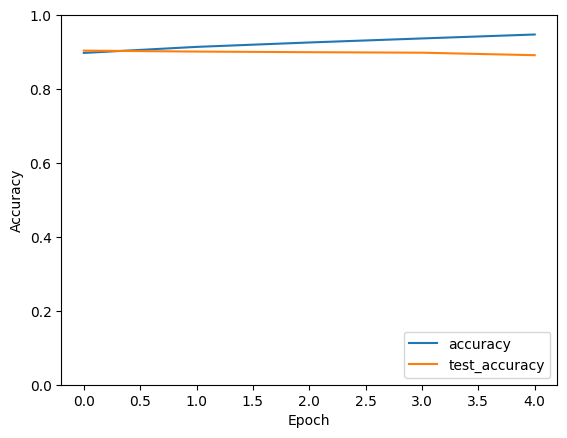

In [17]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [23]:
predictions = model.predict(x_test_pad)
predictions = np.around(predictions.flatten())
y_test = np.around(y_test)
conf_matrix = confusion_matrix(y_test, predictions)

597/597 [==============================] - 9s 16ms/step


In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      9558
           1       0.88      0.90      0.89      9535

    accuracy                           0.89     19093
   macro avg       0.89      0.89      0.89     19093
weighted avg       0.89      0.89      0.89     19093



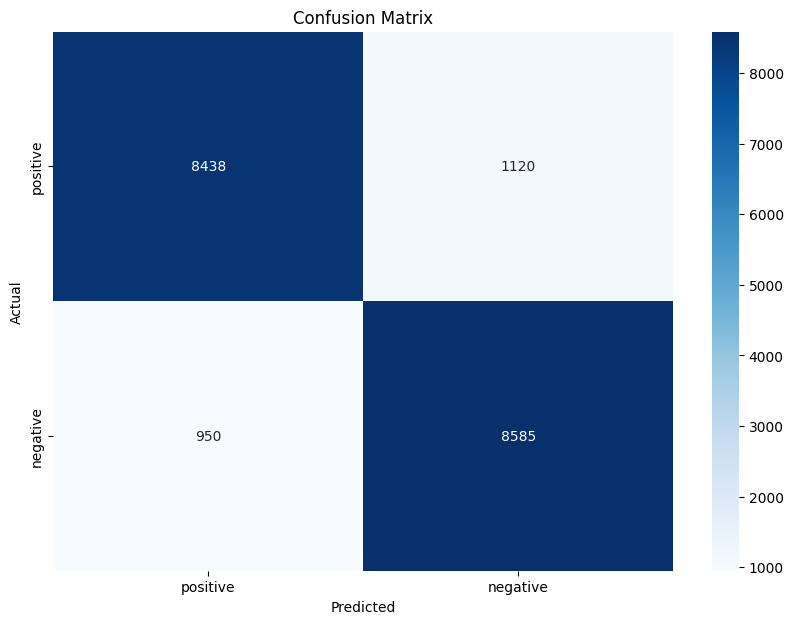

In [25]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'negative'], columns = ['positive', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()